In [1]:
import os
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import tqdm

from char import GPT, CharDataset, get_text, SampleCallback

%matplotlib inline

/home/tollie/miniconda3/envs/gpt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [2]:
data_source: str = "linux"
prompt: str = "static bool put_user(struct task_struct *)"

# Load model and dataset (for inference)

In [3]:
models = {
    "game-of-thrones": "f59c64db89104c831f8b42eb90a5b42a.pt",
    "linux": "6d233ed3f0da24a35a5eca5f75857ba4.pt",
    "shakespeare": "6d03991f495314863a04b33f6e865714.pt",
    "wikipedia": "e962585d74e0ef943e3390559808f8d0.pt",
    "midi": "d6793e75651d33642dc4ced7f58923fa.pt",    
}
assert os.path.isfile(models[data_source])
model = GPT.load_from_checkpoint(models[data_source]).cpu().eval()
n_embedding_dims: int = model.hparams["n_embedding_dims"]
block_size: int = model.hparams["block_size"]
n_attention_heads: int = model.hparams["n_attention_heads"]
n_layers: int = model.hparams["n_layers"]
    
dataset: CharDataset = CharDataset(data=get_text(data_source), block_size=block_size)
    

def get_activation(
    prompt: str, 
    model: GPT, 
    dataset: CharDataset,
    activation: str, 
    layer_i: Optional[int] = None,
) -> np.ndarray:
    """Helper function to do forward pass of the GPT, returns activations as array."""
    
    def fn() -> torch.Tensor:
        model.eval()
        x: torch.Tensor = torch.tensor(
            [dataset.stoi[char] for char in prompt], dtype=torch.long
        )[None, ...].to(model.device)
        if activation == "x":
            return x
        batch_size, block_size = x.shape
        assert (
            block_size <= model.hparams.block_size
        ), "Cannot forward, model block size is exhausted."
        # Each index is mapped to a learnable vector. If we had a different
        # modality to text, such as audio, we could skip the learnable
        # embeddings and feed the raw data directly to the transformer.
        token_embeddings: torch.Tensor = model.char_token_embeddings(x)
        if activation == "token_embeddings":
            return token_embeddings
        # Each position maps to a learnable vector. Other models use sinusoidal
        # embeddings, but this is a simple way to get the job done. This has a
        # shape of (1, block_size, n_embedding_dims).
        position_embeddings: torch.Tensor = model.position_embeddings[:, :block_size, :]
        if activation == "position_embeddings":
            return position_embeddings
        # Add the token and position embeddings together, and apply dropout.
        x = model.embedding_dropout(token_embeddings + position_embeddings)
        if activation == "combined_embeddings":
            return x 
        # Forward pass the transformer blocks. We feed in a shape of
        # (batch_size, block_size, n_embedding_dims) and get back a shape of
        # the same shape: (batch_size, block_size, n_embedding_dims).
        for block_i, block in enumerate(model.blocks):
            x = block(x)
            if activation == "block_attention":
                assert layer_i is not None
                if block_i == layer_i:
                    return block.self_attention.attention
            elif activation == "block_y":
                assert layer_i is not None
                if block_i == layer_i:
                    return block.self_attention.y
            elif activation == "block_mlp":
                assert layer_i is not None
                if block_i == layer_i:
                    return x
        # Apply layer norm.
        x = model.layer_norm(x)
        # Project the `n_embedding_dims dimension (dim=2) of the transformer
        # blocks to the vocab size.
        logits: torch.Tensor = model.head(x)
        if activation == "logits":
            return logits
        else:
            raise ValueError(f"Unrecognised activation: {activation}")
    
    return fn().detach().cpu().numpy()

data has 6546665 characters, 97 unique.


# Position Embeddings

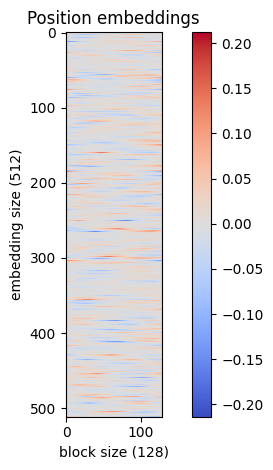

In [4]:
position_embeddings: np.ndarray = model.position_embeddings.detach().numpy().squeeze()
assert position_embeddings.shape == (block_size, n_embedding_dims)
plt.title("Position embeddings")
plt.imshow(position_embeddings.T, cmap="coolwarm")
plt.xlabel(f"block size ({block_size})")
plt.ylabel(f"embedding size ({n_embedding_dims})")
plt.colorbar()
plt.tight_layout()

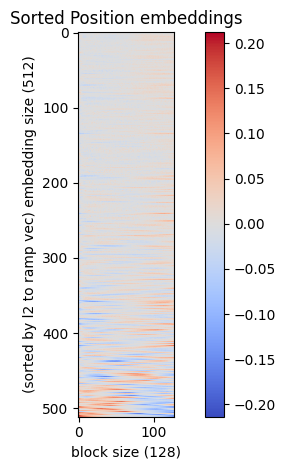

In [6]:
def sort_fn(embedding: List[float]) -> float:
    embedding = np.array(embedding)
    target_vector = np.linspace(embedding.min(), embedding.max(), len(embedding))
    return np.linalg.norm(embedding - target_vector)
    

# Sort by how close to linear ramp in euclidean space the vectors are.
sorted_position_embeddings = np.asarray(
    sorted(position_embeddings.T.tolist(), key=sort_fn)
).T
# Use same imshow code as before.
assert position_embeddings.shape == (block_size, n_embedding_dims)
plt.title("Sorted Position embeddings")
plt.imshow(sorted_position_embeddings.T, cmap="coolwarm")
plt.xlabel(f"block size ({block_size})")
plt.ylabel(f"(sorted by l2 to ramp vec) embedding size ({n_embedding_dims})")
plt.colorbar()
plt.tight_layout()

# Self-Attention Heads

Double click the image to zoom in on the subplots.

layer: 100%|██████████| 8/8 [03:30<00:00, 26.37s/it]


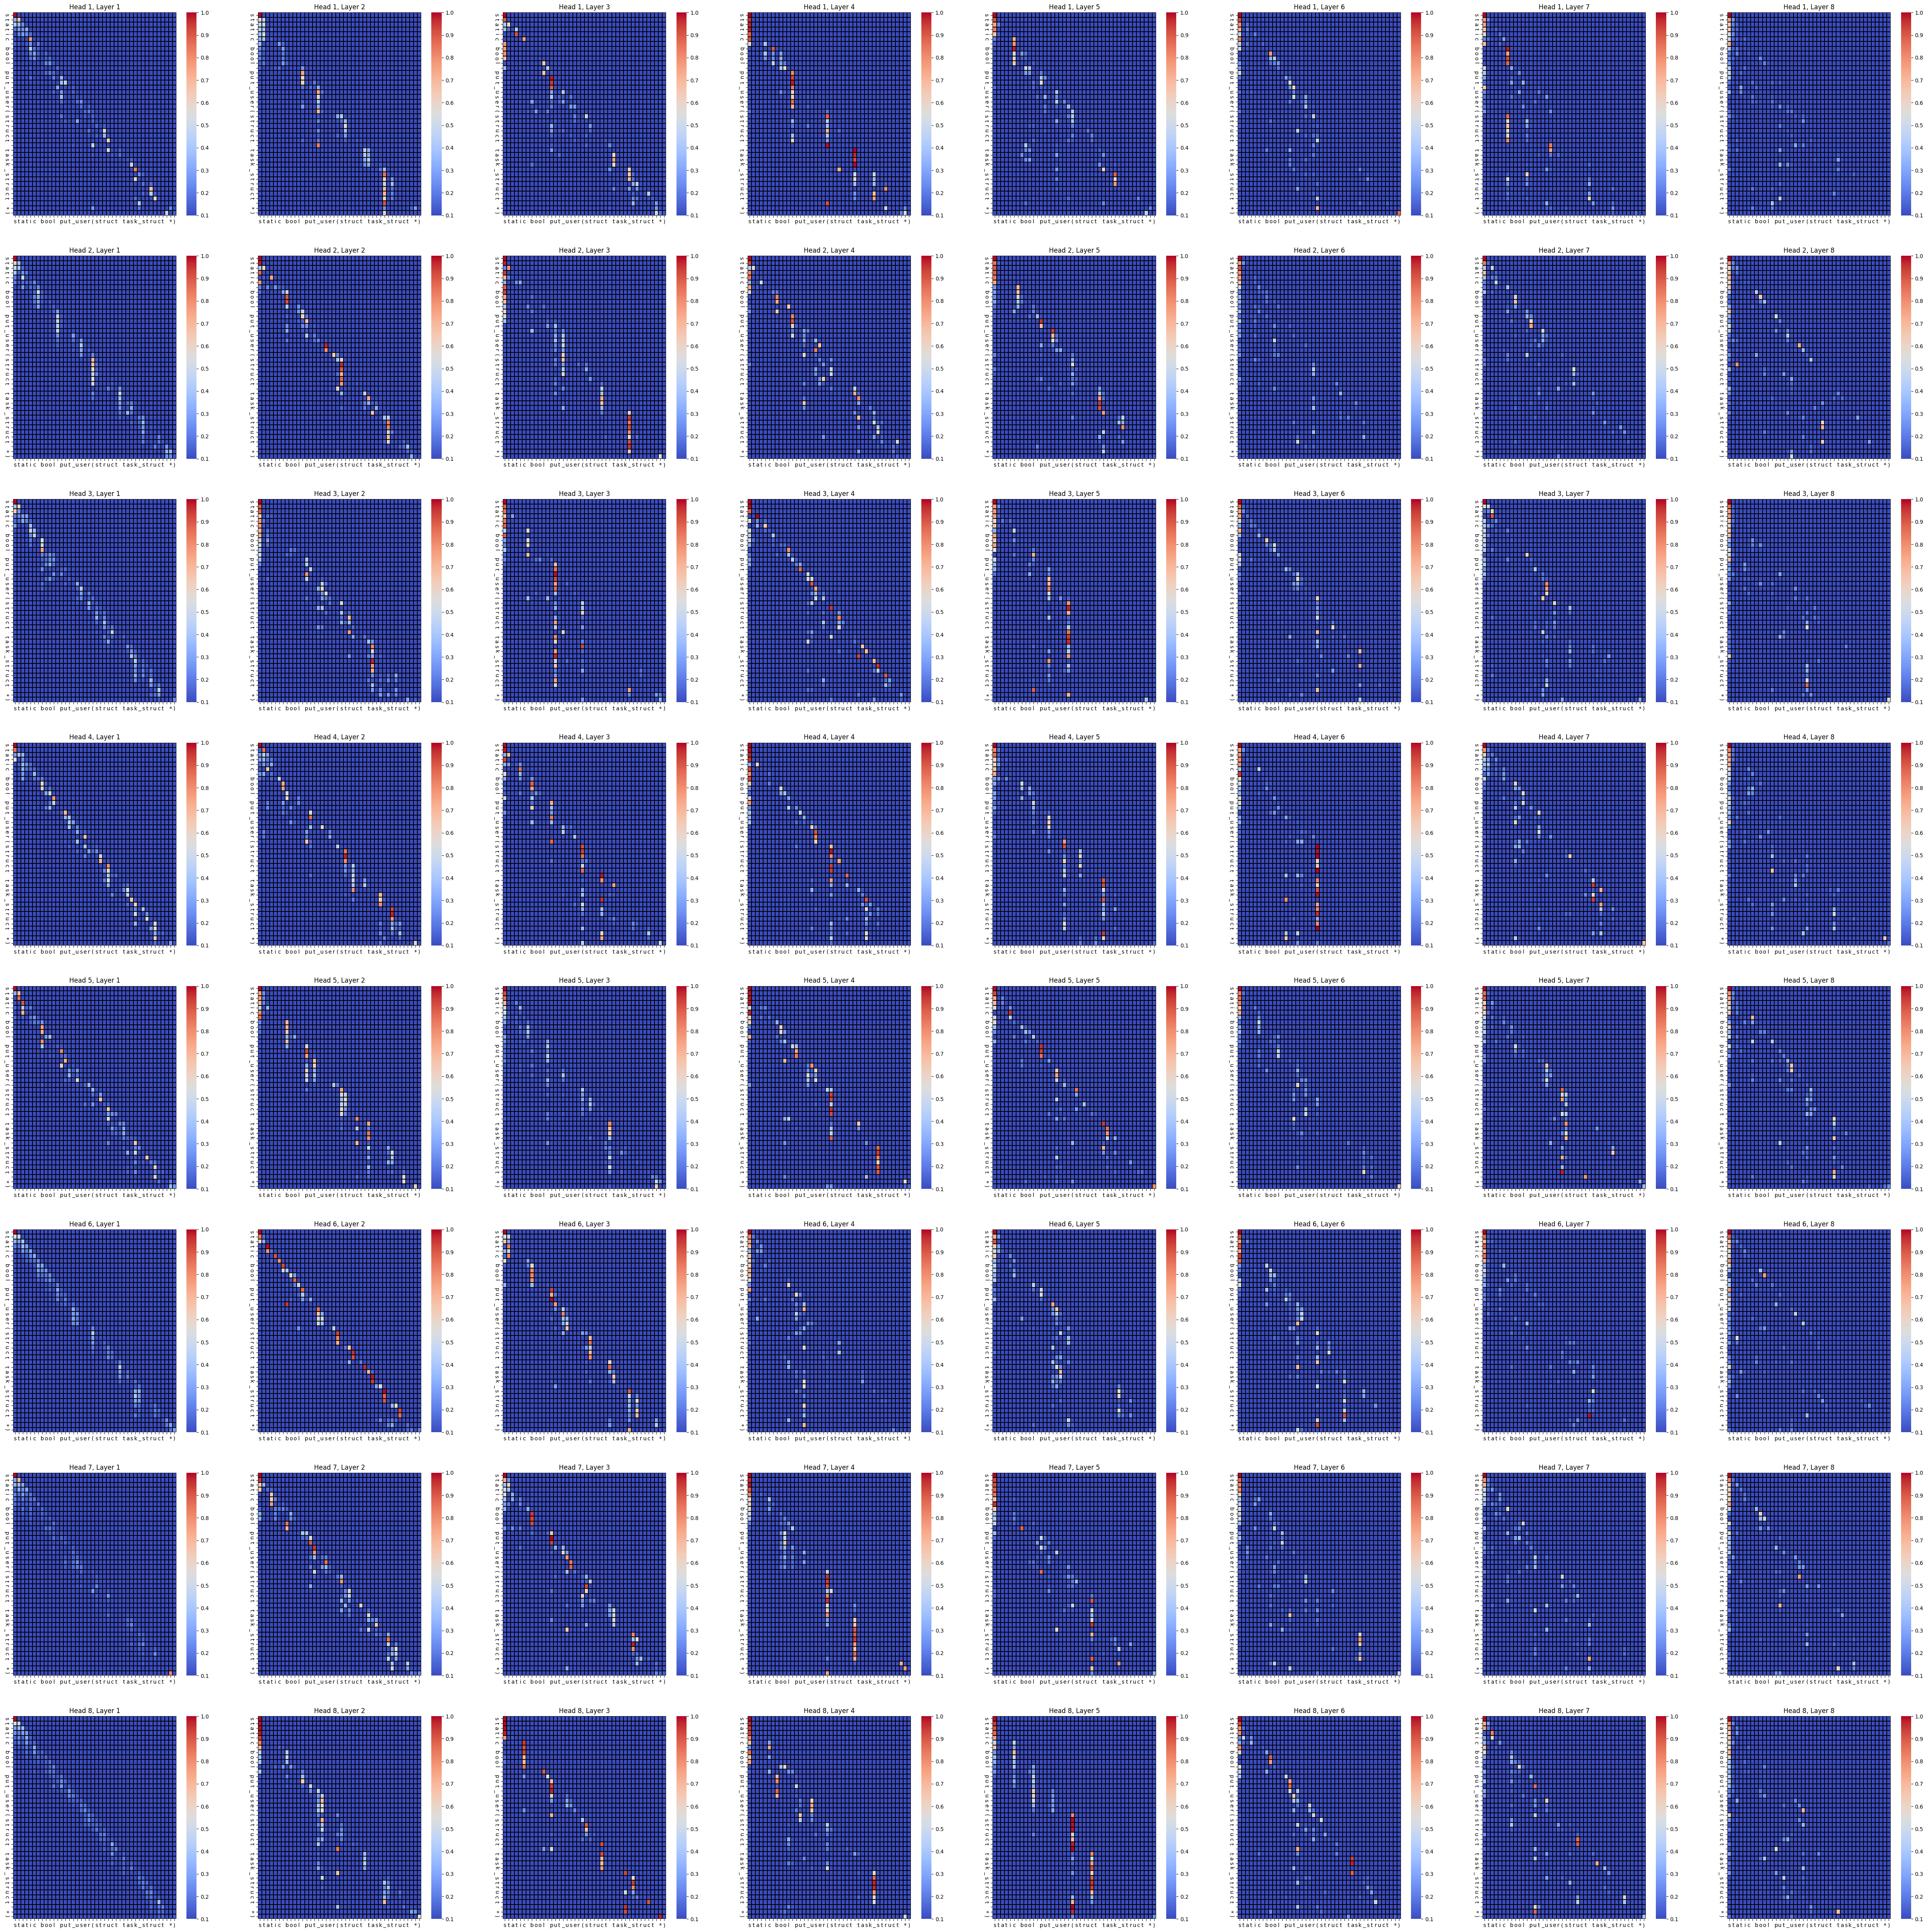

In [23]:
plot_size: float = 8
# Approx the 95th percentile of attention heads in general.
threshold: float = 0.1
n_heads: int = model.blocks[0].self_attention.n_attention_heads
fig, (axes) = plt.subplots(
    n_heads, 
    n_layers, 
    figsize=(plot_size * n_layers, plot_size * n_heads),
)
for layer_i in tqdm.trange(n_layers, desc="layer"):
    attention: torch.Tensor = get_activation(
        prompt=prompt,
        model=model,
        dataset=dataset,
        activation="block_attention",
        layer_i=layer_i
    )
    for head_i in range(n_heads):
        attention_head: np.ndarray = attention[0, head_i, :, :]
        ax = axes[head_i][layer_i]
        ax.set_title(f"Head {head_i + 1}, Layer {layer_i + 1}")
        sns.heatmap(
            data=attention_head,
            xticklabels=list(prompt),
            yticklabels=list(prompt),
            cmap="coolwarm",
            vmin=threshold,
            vmax=1.0,
            linewidth=0.1, 
            linecolor='black', 
            annot_kws={'fontsize': 4}, 
            ax=ax,
            robust=False,
        )
        ax.tick_params(axis='y', labelrotation=270)

# Self-attended value projections

In [78]:
sampler: SampleCallback = SampleCallback(
    context=prompt,
    itos=dataset.itos,
    stoi=dataset.stoi,
    steps=500,
    temperature=0.95,
    top_k=5,
)
result: str = sampler.inference(model)

static bool put_user(struct task_struct *)
			((unsigned long)lock->owner | RT_MUTEX_HAS_WAITERS);
}

static void rt_mutex_handle_deadlock(int res, int detach_id)
{
	struct rt_mutex_waiter *waiter;

	waiter = list_entry(lock->wait_list.next, struct mutex_lock, entry);

	/* now we don't want to change this CPU's cpu @cpu since it
	 * anyway in the failure exit path.
	 */
	list_del(&entry->free_list);
	for (i = 0; i < entry->nb_args; i++) {

		if (list_empty(&arg->wakeup_list)) {
			if (!disable_first)
				goto out;
			size = true;
		}


In [88]:
all_token_embeddings: np.ndarray = np.zeros((len(result), n_embedding_dims))
counts: np.ndarray = np.zeros(len(result))
# Start with the slice being [0:len(prompt)]
end_i: int = len(prompt)
while end_i <= len(result):
    start_i: int = max(0, end_i - block_size)
    model_input: str = result[start_i:end_i]
    attended_token_embeddings: torch.Tensor = get_activation(
        prompt=model_input,
        model=model,
        dataset=dataset,
        activation="block_y",
        layer_i=7
    )
    all_token_embeddings[start_i:end_i] += attended_token_embeddings[0, :, :]
    counts[start_i:end_i] += 1
    end_i += 1

In [93]:
mean_token_embeddings = all_token_embeddings / counts[:, np.newaxis]

In [180]:
from typing import Tuple

def wrap_colored_text(text, colors, W=80, tabsize=4):
    ''' Wrap text with hidden units to certain width '''
    new_text, new_colors = [], []

    # Wrap lines to width
    for char, color in zip(text, colors):
        if char == '\t':
            for i in range(tabsize):
                new_text.append(' ')
                new_colors.append(color)
        else:
            new_text.append(char)
            new_colors.append(color)
            if char == '\n':
                for i in range(W - len(new_text) % W):
                    new_text.append(' ')
                    new_colors.append(np.zeros_like(colors[0]))

    # Add final space to obtain (rectangular) matrix
    for i in range(W - len(new_text) % W):
        new_text.append(' ')
        new_colors.append(np.zeros_like(colors[0]))

    return np.array(new_text).reshape(-1, W), np.array(new_colors).reshape(-1, W)


def interpolate_colours(
    start_colour: Tuple[int, int, int], 
    target_colour: Tuple[int, int, int], 
    x: float,
) -> float:
    """"""
    return (
        (1 - x) * start_colour[0] + x * target_colour[0],
        (1 - x) * start_colour[1] + x * target_colour[1],
        (1 - x) * start_colour[2] + x * target_colour[2],
    )


def plot_text(
    text: str,
    colors: np.ndarray,
    width: int, 
    n_bins: Optional[int] = None,
):
    if n_bins is not None:
        n_bins: int = 6
        bins = np.linspace(np.min(colors), np.max(colors), n_bins)
        digitized = np.digitize(colors, bins)
        colors = bins[digitized - 1]
    wrapped_text, wrapped_colors = wrap_colored_text(text, colors, width, tabsize=8)
    activation_largest_value: float = np.abs(activation).max()
    height: int = len(wrapped_text)
    plt.figure(figsize=(width / 5, height / 3))
    color_palette = sns.color_palette("RdBu_r", 255, desat=.9)
    n_white_steps: int = 7
    for i in range(n_white_steps):
        color_palette[127 + i] = interpolate_colours(
            start_colour=(1., 1., 1.), 
            target_colour=color_palette[127 + i],
            x=i / n_white_steps,
        )
        color_palette[127 - i] = interpolate_colours(
            start_colour=(1., 1., 1.), 
            target_colour=color_palette[127 - i],
            x=i / n_white_steps,
        )
    sns.heatmap(
        wrapped_colors,
        annot=wrapped_text,
        annot_kws={
            'color': 'black',
            'family': 'monospace',
            'horizontalalignment': 'center',
            'fontweight': 'light'
        },
        fmt='s', 
        cbar=True, 
        cmap=color_palette,
        vmin=-activation_largest_value,
        vmax=activation_largest_value,
    )
    plt.xticks([])
    plt.yticks([])
    plt.title(
        f"Activation, range: ({activation.min():.3f}, {activation.max():.3f})"
    )
    plt.tight_layout()
    plt.show()

In [186]:
summed_token_embeddings: np.ndarray = np.zeros((len(result), n_embedding_dims))
max_token_embeddings: np.ndarray = np.zeros((len(result), n_embedding_dims))
min_token_embeddings: np.ndarray = np.zeros((len(result), n_embedding_dims))
counts: np.ndarray = np.zeros(len(result))
# Start with the slice being [0:len(prompt)]
end_i: int = len(prompt)
while end_i <= len(result):
    start_i: int = max(0, end_i - block_size)
    model_input: str = result[start_i:end_i]
    attended_token_embeddings: torch.Tensor = get_activation(
        prompt=model_input,
        model=model,
        dataset=dataset,
        activation="block_y",
        layer_i=7
    )
    summed_token_embeddings[start_i:end_i] += attended_token_embeddings[0, :, :]
    max_token_embeddings[start_i:end_i] = np.maximum(all_token_embeddings[start_i:end_i], attended_token_embeddings[0, :, :])
    min_token_embeddings[start_i:end_i] = np.minimum(all_token_embeddings[start_i:end_i], attended_token_embeddings[0, :, :])
    counts[start_i:end_i] += 1
    end_i += 1
mean_token_embeddings: np.ndarray = summed_token_embeddings / counts[:, np.newaxis]

In [191]:
from sklearn.decomposition import PCA

nd_token_embeddings = PCA(n_components=10).fit_transform(mean_token_embeddings)
nd_token_embeddings.shape

(542, 10)

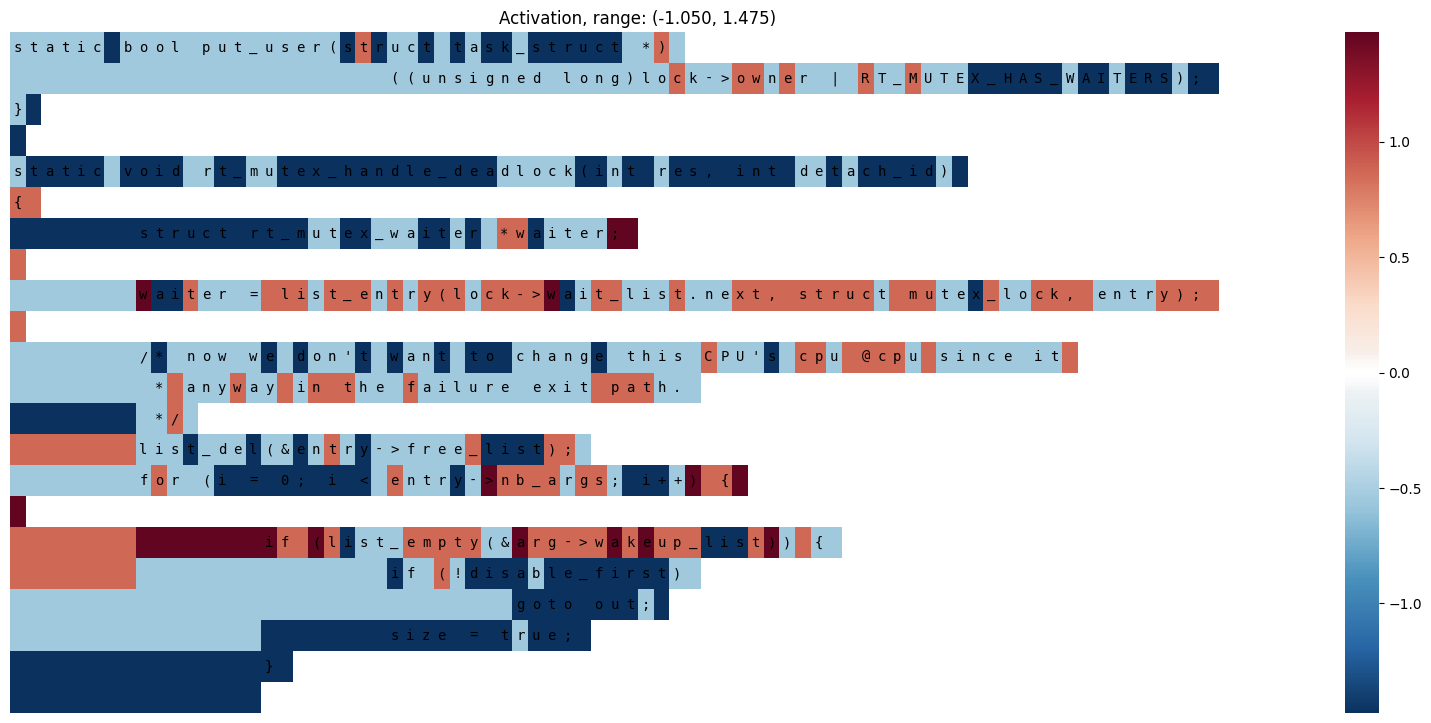

In [207]:
plot_text(
    text=result,
    colors=nd_token_embeddings[:, 9],
    width=80,
    n_bins=10,
)

/home/tollie/miniconda3/envs/gpt/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/home/tollie/miniconda3/envs/gpt/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


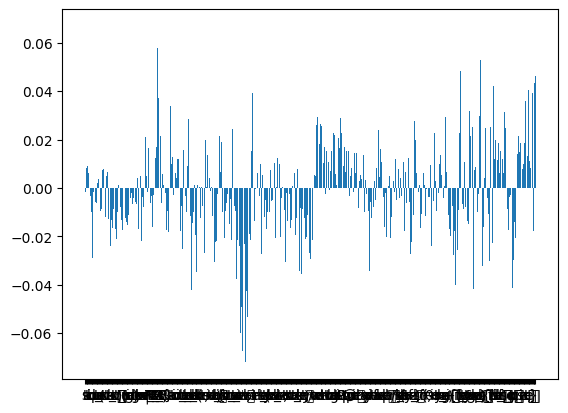

In [102]:

embedding_neuron_i: int = 6
x = np.arange(len(activation))
plt.bar(x, activation)
_ = plt.xticks(x, list(result))

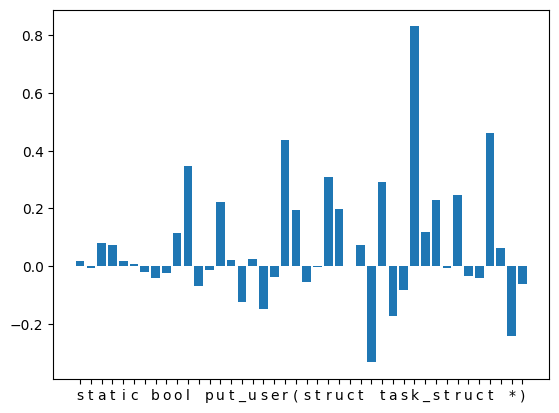

In [69]:
embedding_neuron_i: int = 14
x = np.arange(len(neuron_activation))
neuron_activation: np.ndarray = attended_token_embeddings[0, :, embedding_neuron_i]
plt.bar(x, neuron_activation)
_ = plt.xticks(x, list(prompt))